<a href="https://colab.research.google.com/github/ilgarbuzov/general/blob/master/Lending_Club_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Jeff Bezos**


*   Wants to start lending money to people 
*   Needs us to predict the performance of a given loan or portfolio of loans
*   Build a dashboard as well

**All Lending Club loan data** 
Link https://www.kaggle.com/wordsforthewise/lending-club

In [ ]:
from google.colab import files
files.upload()

Saving accepted_2007_to_2018Q4.csv.gz to accepted_2007_to_2018Q4.csv.gz


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
df = pd.read_csv("../content/accepted_2007_to_2018Q4.csv.gz", compression='gzip')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,...,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,...,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,NaN,NaN,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,...,218418.0,18696.0,6200.0,14877.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,076xx,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,NaN,NaN,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,...,381215.0,52226.0,62500.0,18000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,major_purchase,Major purchase,174xx,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,NaN,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,...,439570.0,95768.0,20300.0,88097.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,...,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260664e+06,2.258957e+06,2.260639e+06,2.260668e+06,2.260668e+06,2.260638e+06,1.102166e+06,359156.000000,2.260639e+06,2.260639e+06,2.260668e+06,2.258866e+06,2.260639e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260523e+06,580775.000000,2260668.0,1.207100e+05,120706.000000,2.260639e+06,2.190392e+06,2.190392e+06,1.394538e+06,...,2.190392e+06,2.190392e+06,2.190392e+06,2.190391e+06,2.190392e+06,2.202078e+06,2.107011e+06,2.190392e+06,2.190392e+06,2.190392e+06,2.190237e+06,2.185289e+06,2.259303e+06,2.260563e+06,2.190392e+06,2.210638e+06,2.210638e+06,2.190392e+06,1.080200e+05,108021.000000,108021.000000,108021.000000,108021.000000,108021.000000,106184.000000,108021.000000,108021.000000,108021.000000,108021.000000,35942.000000,10917.0,10917.000000,10917.0,10917.000000,8651.000000,10917.000000,10917.000000,34246.000000,34246.000000,34246.000000
mean,NaN,1.504693e+04,1.504166e+04,1.502344e+04,1.309283e+01,4.458068e+02,7.799243e+04,1.882420e+01,3.068792e-01,6.985882e+02,7.025884e+02,5.768354e-01,3.454092e+01,72.312842,1.161240e+01,1.975278e-01,1.665846e+04,5.033770e+01,2.416255e+01,4.206891e+03,4.205965e+03,1.208256e+04,1.206439e+04,9.505772e+03,2.431388e+03,1.518453e+00,1.438791e+02,2.398257e+01,3.429346e+03,6.876610e+02,6.755397e+02,1.814580e-02,44.164220,1.0,1.236246e+05,19.251817,4.147942e-03,2.327317e+02,1.424922e+05,9.344199e-01,...,7.726402e+00,8.413439e+00,8.246523e+00,1.400463e+01,5.577951e+00,1.162813e+01,6.373958e-04,2.813652e-03,8.293767e-02,2.076755e+00,9.411458e+01,4.243513e+01,1.281935e-01,4.677109e-02,1.782428e+05,5.102294e+04,2.319377e+04,4.373201e+04,3.361728e+04,669.755603,673.755631,0.633256,1.538997,11.469455,58.169101,3.010554,12.533072,0.046352,0.077568,36.937928,3.0,155.045981,3.0,13.743886,454.798089,11636.883942,193.994321,5010.664267,47.780365,13.191322
std,NaN,9.190245e+03,9.188413e+03,9.192332e+03,4.832138e+00,2.671735e+02,1.126962e+05,1.418333e+01,8.672303e-01,3.301038e+01,3.301124e+01,8.859632e-01,2.190047e+01,26.464094,5.640861e+00,5.705150e-01,2.294831e+04,2.471307e+01,1.198753e+01,7.343239e+03,7.342333e+03,9.901383e+03,9.896992e+03,8.321852e+03,2.679738e+03,1.184159e+01,7.481640e+02,1.312256e+02,6.018248e+03,7.297044e+01,1.110976e+02,1.508131e-01,21.533121,0.0,7.416135e+04,7.822086,6.961656e-02,8.518462e+03,1.606926e+05,1.140700e+00,...,4.701430e+00,7.359114e+00,4.683928e+00,8.038868e+00,3.293434e+00,5.644027e+00,2.710643e-02,5.616522e-02,4.935732e-01,1.830711e+00,9.036140e+0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


**Data visualization and feature enigineering**

In [ ]:
#transform the loan-status into a binary variable where 'Charged Off' = 1 and 'Fully Paid' = 0.
df['loan_status_bin'] = df['loan_status'].map({'Charged Off': 1, 'Fully Paid': 0})

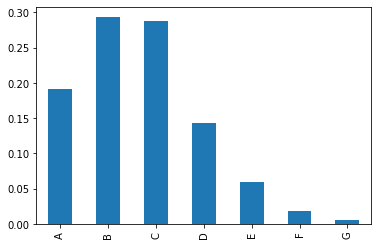

In [ ]:
#distribution of grades

(df['grade'].value_counts().sort_index()/len(df)).plot.bar()

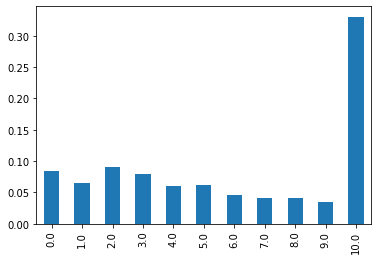

In [ ]:
# distribution of the employment length

def emp_to_num(term):
    if pd.isna(term):
        return None
    elif term[2]=='+':
        return 10
    elif term[0]=='<':
        return 0
    else:
        return int(term[0])

df['emp_length_num'] = df['emp_length'].apply(emp_to_num)
(df['emp_length_num'].value_counts().sort_index()/len(df)).plot.bar()

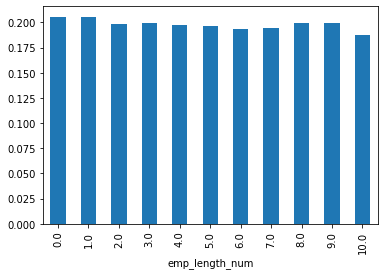

In [ ]:
# connection between employment length and default rate

df.groupby('emp_length_num')['loan_status_bin'].mean().plot.bar()

In [ ]:
df['long_emp'] = df['emp_length'].apply(lambda x: 1*(x=='10+ years'))
df['short_emp'] = df['emp_length'].apply(lambda x: 1*(x=='1 year' or x=='< 1 year'))

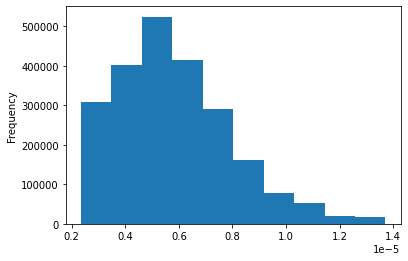

In [ ]:
# the distirubtion of the interest rates

(df['int_rate']/len(df)).plot.hist(bins=10)

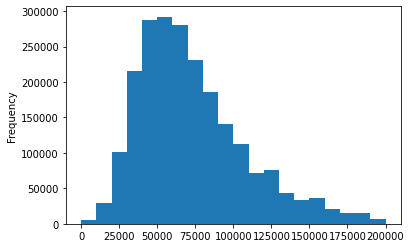

In [ ]:
#the distribution of the annual income

df[df['annual_inc']<200000]['annual_inc'].plot.hist(bins=20)
df['annual_inc_log'] = df['annual_inc'].apply(np.log)

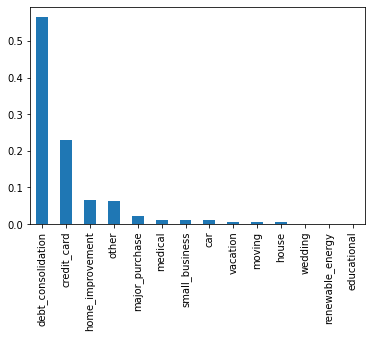

In [ ]:
#the most common reasons for requesting a loan

(df['purpose'].value_counts()/len(df)).plot.bar()

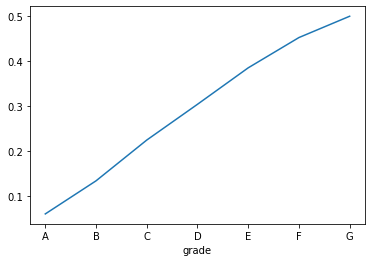

In [ ]:
#connection between grades and default rate

df.groupby('grade')['loan_status_bin'].mean().plot.line()

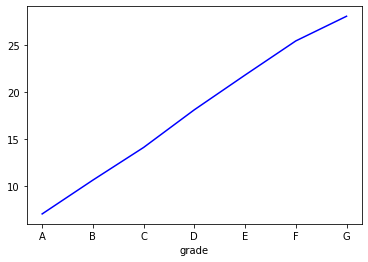

In [ ]:
#connection between grades and interest rate

df.groupby('grade')['int_rate'].mean().plot.line(color='blue')

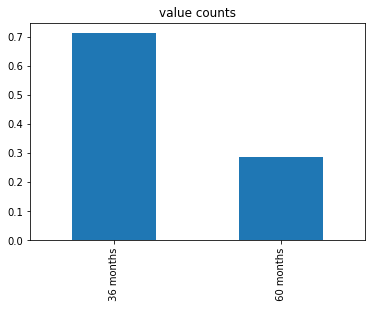

In [ ]:
#the distribution of loan term

(df['term'].value_counts()/len(df)).plot.bar(title='value counts')

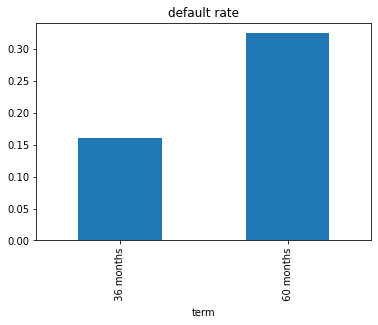

In [ ]:
#connection between term and default rate

df.groupby('term')['loan_status_bin'].mean().plot.bar(title='default rate')

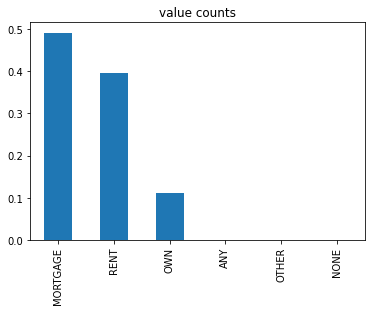

In [ ]:
#the distribution of home_ownership feature

(df['home_ownership'].value_counts()/len(df)).plot.bar(title='value counts')

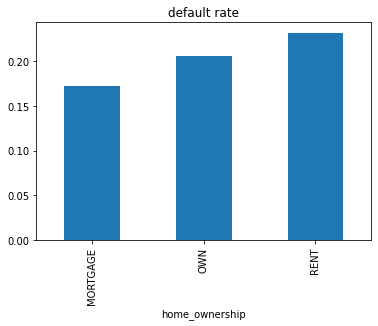

In [ ]:
#connection between home_ownership feature and default rate

df[(df['home_ownership']=='MORTGAGE') | (df['home_ownership']=='OWN')| (df['home_ownership']=='RENT')].groupby('home_ownership')['loan_status_bin'].mean().plot.bar(title='default rate')

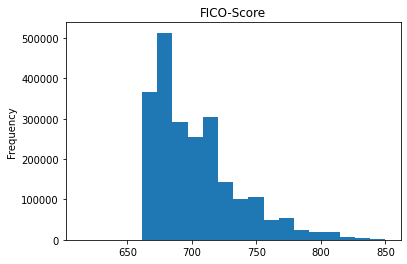

In [ ]:
#the distribution of FICO score (FICO, originally Fair, Isaac and Company, is a data analytics company based in San Jose, California focused on credit scoring services)

df['fico_range_high'].plot.hist(bins=20, title='FICO-Score')

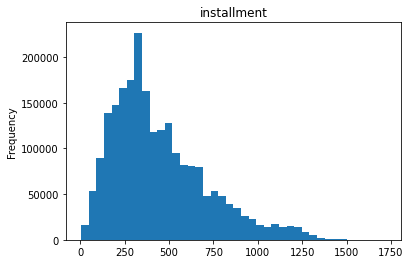

In [ ]:
#the distribution of installment (An installment loan is a type of agreement or contract involving a 
# loan that is repaid over time with a set number of scheduled payments; normally at least two payments are made towards the loan)

df['installment'].plot.hist(bins=40, title='installment')

**Describing the linear connection between default and interest rate**

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(df.groupby('sub_grade')['loan_status_bin'].mean().values.reshape(-1,1), y=df.groupby('sub_grade')['int_rate'].mean())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Text(0, 0.5, 'interest rate')

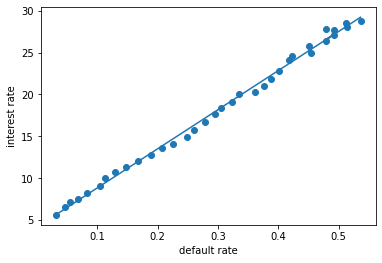

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(df.groupby('sub_grade')['loan_status_bin'].mean(), df.groupby('sub_grade')['int_rate'].mean())
plt.plot(df.groupby('sub_grade')['loan_status_bin'].mean(), lr.predict(df.groupby('sub_grade')['loan_status_bin'].mean().values.reshape(-1,1)))
plt.xlabel('default rate')
plt.ylabel('interest rate')

In [ ]:
print('interest rate = ', lr.intercept_, '+', lr.coef_[0], '* default rate')

interest rate =  4.129251941104965 + 46.81094216203075 * default rate


**Training the Logistic Regression**

In [ ]:
#Reduce the dataset to the following columns that are known to investors before the loan is funded.

columns = ['loan_amnt', 'term', 'int_rate',
       'installment', 'grade', 'emp_length',
       'home_ownership', 'annual_inc_log', 'verification_status',
       'loan_status_bin', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs',
       'fico_range_low', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc']
df = df[columns]

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.shape

(1265975, 21)

In [ ]:
df['grade']=df['grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})

In [ ]:
df_dummies = pd.get_dummies(df) #get dummy for categorical features

In [ ]:
drop_columns = df_dummies.columns[(df_dummies.mean()<0.01)] #drop all dummy-variables which contain not at least 1% ones
df_dummies.drop(drop_columns, axis=1, inplace=True)

In [ ]:
df_dummies.head()

,loan_amnt,int_rate,installment,grade,annual_inc_log,loan_status_bin,dti,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,term_ 36 months,term_ 60 months,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_major_purchase,purpose_medical,purpose_other,purpose_small_business,addr_state_AL,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_FL,addr_state_GA,addr_state_IL,addr_state_IN,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_NC,addr_state_NJ,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OR,addr_state_PA,addr_state_SC,addr_state_TN,addr_state_TX,addr_state_VA,addr_state_WA,addr_state_WI
0,3600.0,13.99,123.03,3,10.915088,0.0,5.91,0.0,675.0,1.0,7.0,0.0,2765.0,29.7,13.0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,24700.0,11.99,820.28,3,11.082143,0.0,16.06,1.0,715.0,4.0,22.0,0.0,21470.0,19.2,38.0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,20000.0,10.78,432.66,2,11.050890,0.0,10.78,0.0,695.0,0.0,6.0,0.0,7869.0,56.2,18.0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10400.0,22.45,289.91,6,11.556301,0.0,25.37,1.0,695.0,3.0,12.0,0.0,21929.0,64.5,35.0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,11950.0,13.44,405.18,3,10.434116,0.0,10.20,0.0,690.0,0.0,5.0,0.0,8822.0,68.4,6.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = df_dummies.drop('loan_status_bin', axis=1)
y = df_dummies['loan_status_bin']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

sc = MinMaxScaler()
clf = LogisticRegression(penalty='l1', C=0.01, solver='liblinear')

pipe_lr = Pipeline([('scaler', sc), ('clf', clf)])

In [ ]:
pipe_lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('clf',
                 LogisticRegression(C=0.01, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
#Training with LR.score:

pipe_lr.score(X_train, y_train) #accuracy rate

0.8057248365884002

ROC-AUC-score:  0.7114899093764288


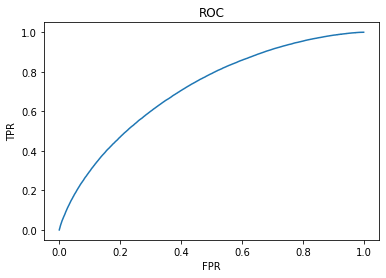

In [ ]:
test_probas = pipe_lr.predict_proba(X_test)[:,1]
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

fpr, tpr, tresholds = roc_curve(y_test, test_probas)
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')

print('ROC-AUC-score: ', roc_auc_score(y_test, test_probas))

In [ ]:
#Testing with LR.score:

accuracy_score(y_test, pipe_lr.predict(X_test))

0.8059440352297637

In [ ]:
#which features are most important

for i in np.argsort(-np.abs(pipe_lr.named_steps['clf'].coef_[0])):
    print(X.columns[i], ': ', round(pipe_lr.named_steps['clf'].coef_[0,i], 2))

dti :  4.3
annual_inc_log :  -3.46
open_acc :  2.01
fico_range_low :  -1.48
total_acc :  -1.17
grade :  1.16
installment :  0.77
int_rate :  0.72
term_ 60 months :  0.57
inq_last_6mths :  0.55
addr_state_OR :  -0.36
purpose_small_business :  0.32
addr_state_CO :  -0.29
addr_state_WA :  -0.28
addr_state_SC :  -0.19
addr_state_LA :  0.19
home_ownership_RENT :  0.17
home_ownership_MORTGAGE :  -0.17
addr_state_AL :  0.15
purpose_credit_card :  -0.13
purpose_car :  -0.13
addr_state_CT :  -0.12
verification_status_Not Verified :  -0.11
addr_state_IL :  -0.1
addr_state_GA :  -0.08
purpose_medical :  0.08
addr_state_NY :  0.07
addr_state_MO :  0.07
addr_state_NV :  0.07
addr_state_NJ :  0.06
term_ 36 months :  -0.06
addr_state_FL :  0.05
addr_state_MD :  0.05
addr_state_IN :  0.05
addr_state_WI :  -0.05
addr_state_CA :  -0.04
verification_status_Source Verified :  0.04
purpose_debt_consolidation :  -0.04
addr_state_TN :  0.04
addr_state_TX :  0.03
addr_state_NC :  0.02
purpose_home_improvement